In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
from torch_geometric.data import DataLoader, InMemoryDataset,DataListLoader
import time
import importlib
from sklearn.metrics import roc_curve, roc_auc_score

In [2]:
classifiers = ['energy','type','class']
classifying = classifiers[0]

path = 'C:/Users/jv97/Desktop/github/Neutrino-Machine-Learning'

class LoadDataset(InMemoryDataset):
    def __init__(self, name, root = path + '/train_test_datasets'):
        super(LoadDataset, self).__init__(root)
        self.data, self.slices = torch.load(root + '/' + name)
    
    @property
    def processed_file_names(self):
        return os.listdir(root)
    
    def reload(self):
        for data_list in DataListLoader(self,batch_size=self.__len__()):
            pass
        # self.data, self.slices = self.collate(data_list)
        return Dataset(*self.collate(data_list))

class Dataset(InMemoryDataset):
    def __init__(self, data,slices, root = path + '/train_test_datasets'):
        super(Dataset, self).__init__(root)
        self.data, self.slices = data, slices
    
    @property
    def processed_file_names(self):
        return os.listdir(root)
        
    def reload(self):
        for data_list in DataListLoader(self,batch_size=self.__len__()):
            pass
        # self.data, self.slices = self.collate(data_list)
        return Dataset(*self.collate(data_list))

In [3]:
print(f'Loading datasets for {classifying} prediction')

train_dataset = LoadDataset('t70k_e70k_m70k_muon38730')
test_dataset = LoadDataset('t30k_e30k_m30k_muon90k')

train_dataset = train_dataset[70000:210000].reload()
test_dataset = test_dataset[30000:90000].reload()

train_dataset.data.y = train_dataset.data.y[::8]
train_dataset.slices['y'] = np.arange(train_dataset.__len__() + 1)
test_dataset.data.y = test_dataset.data.y[::8]
test_dataset.slices['y'] = np.arange(test_dataset.__len__() + 1)

Loading datasets for energy prediction


In [4]:
train_loader = DataLoader(train_dataset, batch_size=512,shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=512)

In [41]:
print('Loads model')
#Define model:
#The syntax is for model i: from Models.Model{i} import Net
import Models.Model2 as Model
Model = importlib.reload(Model)

print(f'remember to double check that model is suitable for {classifying} prediction')
if not torch.cuda.is_available(): print('CUDA not available') 

# print(f'Memory before .to(device) {torch.cuda.memory_allocated()}')

Loads model
remember to double check that model is suitable for energy prediction


In [42]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Model.Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

# print(f'Memory after .to(device) {torch.cuda.memory_allocated()}')

In [43]:
# # For loading existing model and optimizer parameters.
# print('Loading existing model and optimizer states')
# state = torch.load('Trained_Models/Model8_Class.pt')
# model.load_state_dict(state['model_state_dict'])
# optimizer.load_state_dict(state['optimizer_state_dict'])

def save_model(name):
    torch.save({'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()},'Trained_Models/'+name)
    print('Model saved')

In [44]:
if classifying == classifiers[0]: #Energy prediction
    crit = torch.nn.MSELoss()

    def cal_acc(output,label):
        return (output.view(-1) - label).float().mean().item()

elif classifying == classifiers[1]: #Type prediction
    crit = torch.nn.NLLLoss()

    def cal_acc(output,label):
        return output.argmax(dim=1).eq(label).float().mean().item()

elif classifying == classifiers[2]: #Class prediction
    crit = torch.nn.NLLLoss()

    def cal_acc(output,label):
        return output.argmax(dim=1).eq(label).float().mean().item()

In [45]:
batch_loss, batch_acc = [], []
def train():
    model.train()

    for data in train_loader:
        data = data.to(device)
        label = data.y
        optimizer.zero_grad()
        output = model(data)
        del data
        loss = crit(output,label)
        loss.backward()
        optimizer.step()

        batch_loss.append(loss.item())
        batch_acc.append(cal_acc(output,label))

    torch.cuda.empty_cache()
    return

In [46]:
def test():
    acc = 0
    model.eval()
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            label = data.y
            output = model(data)

            del data

            acc += cal_acc(output,label)
        torch.cuda.empty_cache()
    return acc/test_loader.__len__()

In [47]:
def ROC():
    model.eval()
    scores = []
    labels = []
    with torch.no_grad():
        for data in test_loader:
            label = data.y
            data = data.to(device)
            output = model(data)

            del data

            scores += output.cpu()[:,0].tolist()

            del output
            # print(torch.cuda.memory_allocated())
            labels += label.cpu().tolist()
        torch.cuda.empty_cache()
    return scores, labels

In [48]:
def epochs(i,mean_length=50):
    print('Begins training')
    t0 = time.time()
    for epoch in range(i):
        print(f'Epoch: {epoch}')
        train()
        mean_loss = np.mean(batch_loss[-mean_length:])
        mean_acc = np.mean(batch_acc[-mean_length:])
        std_acc = np.std(batch_acc[-mean_length:])
        print(f'Mean of last {mean_length} batches; loss: {mean_loss}, acc: {mean_acc} +- {std_acc}')
        print(f'time since beginning: {time.time() - t0}')
        print('Done')

In [103]:
epochs(20)

Begins training
Epoch: 0
Mean of last 50 batches; loss: 10.489249362945557, acc: -0.11171651683747769 +- 0.7674410775701425
time since beginning: 52.34771418571472
Done
Epoch: 1
Mean of last 50 batches; loss: 3.7477129197120664, acc: -0.1346583132818341 +- 0.44299420413805063
time since beginning: 103.68927025794983
Done
Epoch: 2
Mean of last 50 batches; loss: 3.345324466228485, acc: -0.13396004289388658 +- 0.5732591458702618
time since beginning: 155.26194977760315
Done
Epoch: 3
Mean of last 50 batches; loss: 2.7768323719501495, acc: -0.13582533799111843 +- 0.9547675111634102
time since beginning: 206.76162385940552
Done
Epoch: 4
Mean of last 50 batches; loss: 58.07040995597839, acc: -0.2034717717766762 +- 6.60245204212952
time since beginning: 258.26482915878296
Done
Epoch: 5
Mean of last 50 batches; loss: 1.3271799808740616, acc: -0.1351303320378065 +- 0.6441041783119207
time since beginning: 310.1435577869415
Done
Epoch: 6
Mean of last 50 batches; loss: 1.4916625821590423, acc: -0.

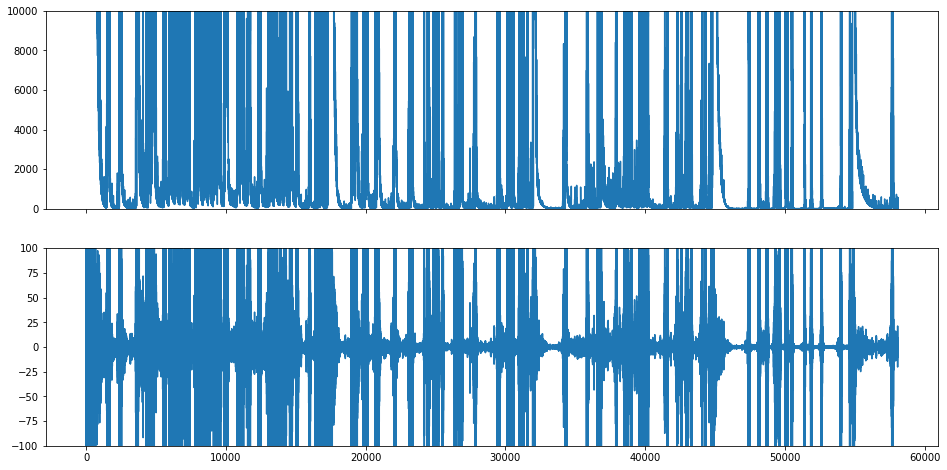

In [104]:
fig, ax = plt.subplots(nrows=2,sharex=True,figsize=(16,8))
ax[0].plot(batch_loss)
ax[1].plot(batch_acc)
ax[0].set_ylim(0,10000)
ax[1].set_ylim(-100,100)
fig.show()

In [109]:
numu = test_dataset[140000:210000].reload()
mu = test_dataset[210000:].reload()
numu_energy = numu.data.y[::8]
mu_energy = mu.data.y[::8]

val_numu, bins_numu = np.histogram(numu_energy,bins=200,range=(1.9,2.7))
val_mu, bins_mu = np.histogram(mu_energy,bins=200,range=(1.9,2.7))

binc = 0.5*(bins_mu[1:] + bins_mu[:-1])

In [110]:
maxes = np.argmin(np.array([val_numu,val_mu]),axis=0)
maxvals = []
for i in range(len(maxes)):
    maxvals.append([val_numu,val_mu][maxes[i]][i])

In [111]:
datalist = []

for i in range(len(maxvals)):
    mask = (numu_energy>=bins_numu[i])*(numu_energy<bins_numu[i+1])
    valid_ind = np.arange(numu.__len__())[mask]
    for event in numu[np.random.choice(valid_ind,maxvals[i],replace=False).tolist()]:
        datalist.append(event)

In [114]:
for i in range(len(maxvals)):
    mask = (mu_energy>=bins_mu[i])*(mu_energy<bins_mu[i+1])
    valid_ind = np.arange(mu.__len__())[mask]
    for event in mu[np.random.choice(valid_ind,maxvals[i],replace=False).tolist()]:
        datalist.append(event)

In [117]:
class MakeDataset(InMemoryDataset):
    def __init__(self, root,data_list,name):
        super(MakeDataset, self).__init__(root)
        self.data, self.slices = self.collate(data_list)
        torch.save((self.data,self.slices),root+'/'+name)

    @property
    def processed_file_names(self):
        return os.listdir('C:/Users/jv97/Desktop/github/Neutrino-Machine-Learning/train_test_datasets')

    def process(self):
        pass

In [118]:
MakeDataset('C:/Users/jv97/Desktop/github/Neutrino-Machine-Learning/train_test_datasets',datalist,'m_muon_overlap')

Processing...
Done!


MakeDataset(15472)

In [120]:
test_dataset = LoadDataset('m_muon_overlap')
test_loader = DataLoader(test_dataset, batch_size=512)

In [126]:
test_dataset.data.y = torch.tensor(np.append(np.zeros(test_dataset.__len__()//2),np.ones(test_dataset.__len__()//2)),dtype=torch.int64)
test_dataset.slices['y'] = np.arange(test_dataset.__len__()+1)

In [127]:
a,b = ROC()

In [130]:
c = roc_curve(b,a)

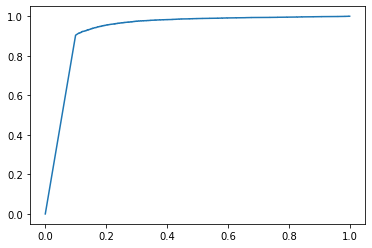

In [131]:
fig, ax = plt.subplots()
ax.plot(c[1],c[0])

In [143]:
# fig, ax = plt.subplots()
len(a)

15472